In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('../Data/processed/Telco-Customer-Churn-Encoded.csv')

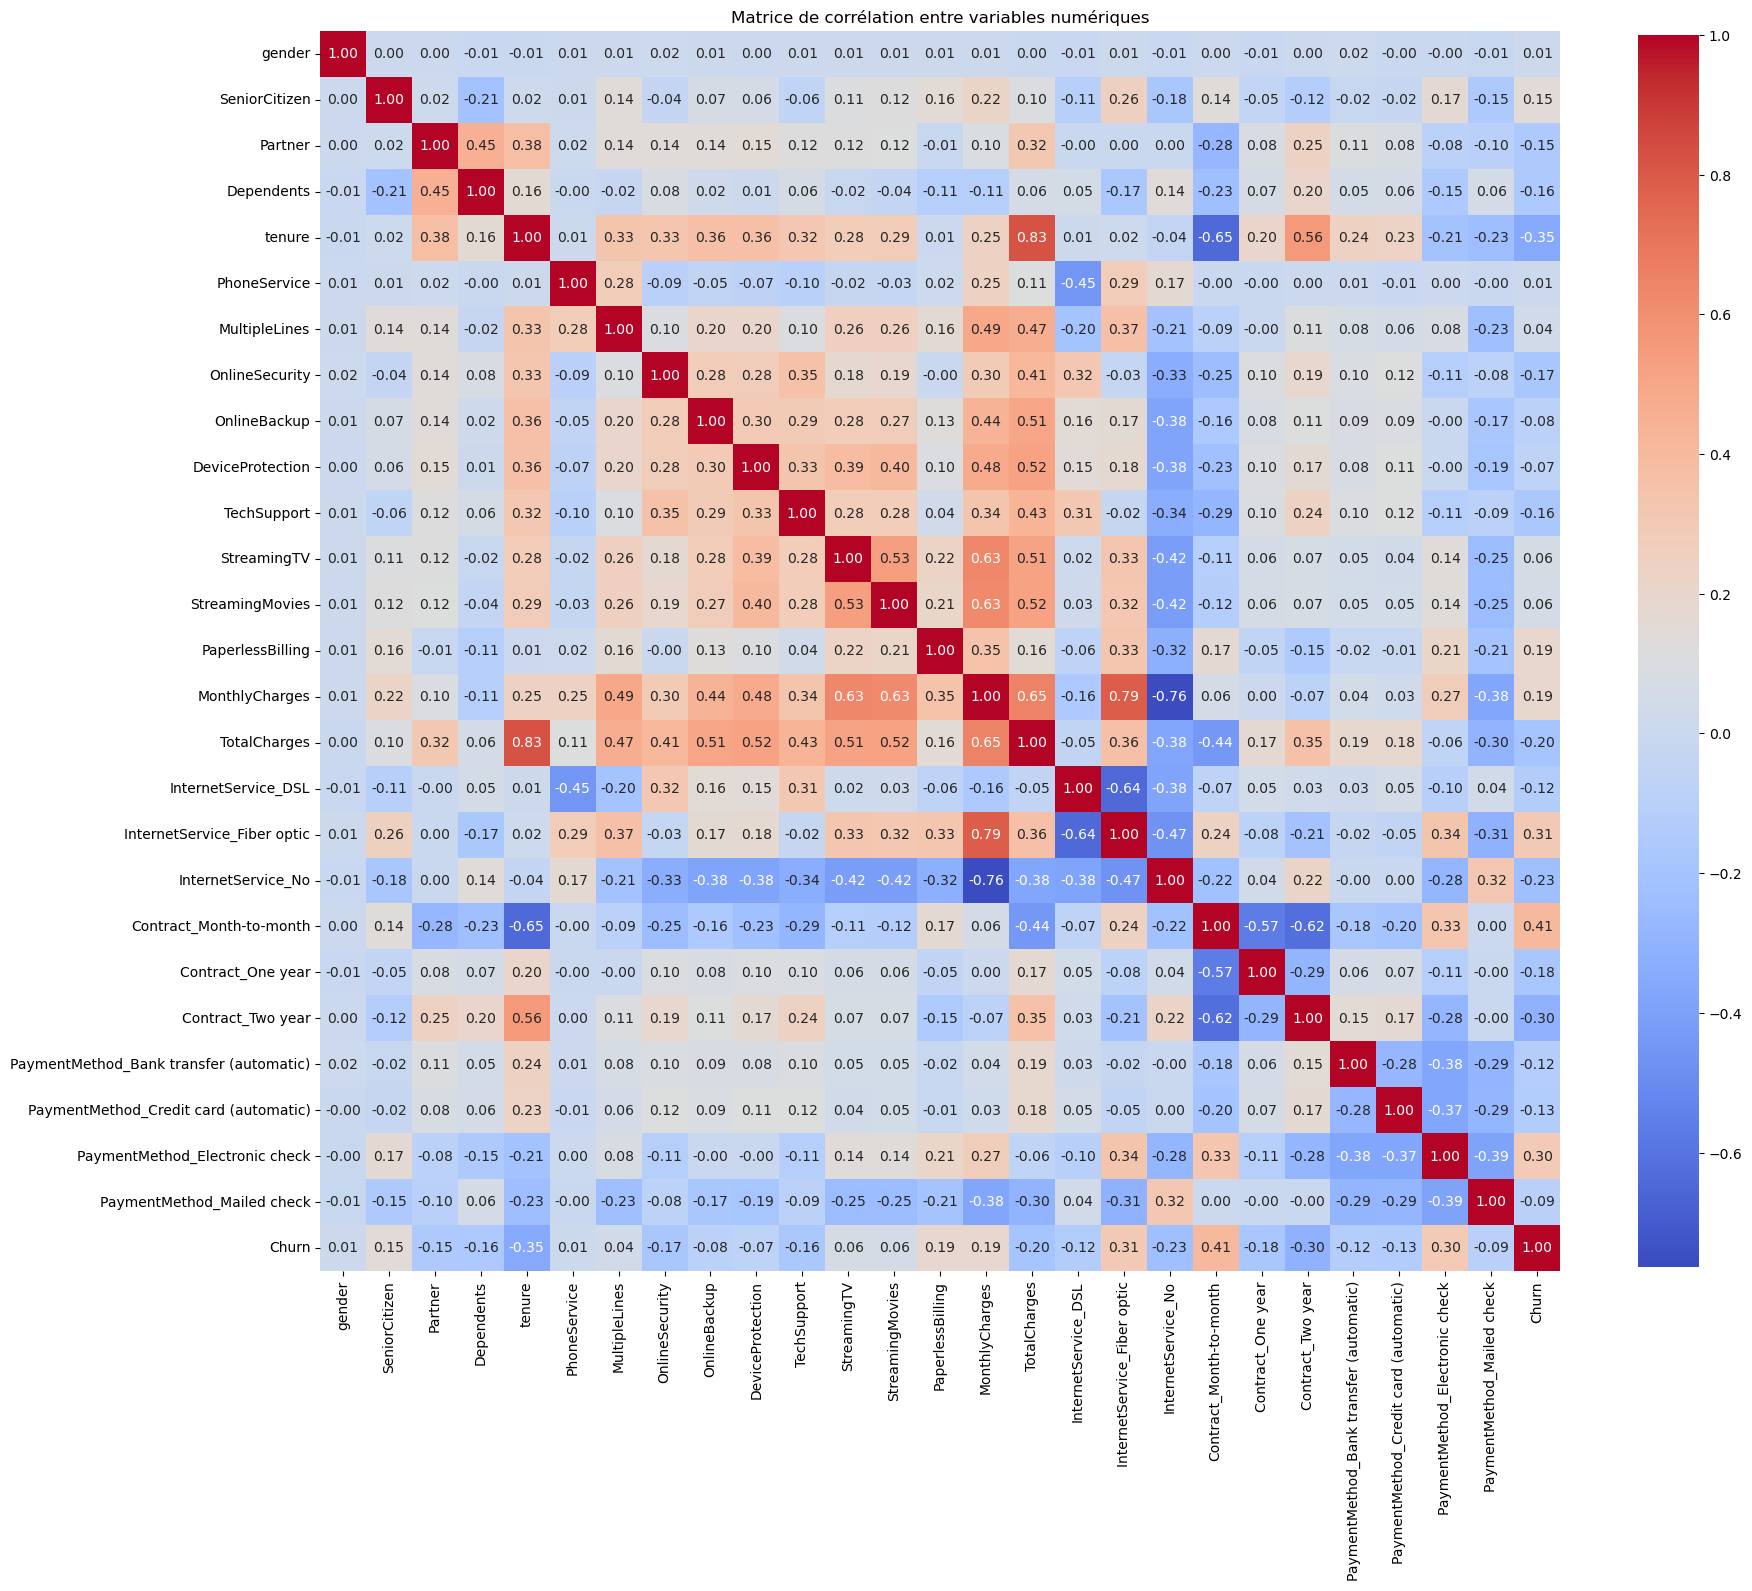

In [5]:
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Matrice de corrélation entre variables numériques")
plt.savefig("../reports/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Observation 
on remarque un corrélation forte entre les charge total et l'ancienté des clients  

In [6]:
# remove the 'TotalCharges' column
df.drop(columns=['TotalCharges'], inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn']), df['Churn'], test_size=0.2, random_state=42)

In [8]:
num_col = ['tenure', 'MonthlyCharges']

### Normalisation des données

In [9]:
scaler = StandardScaler()
X_train_ss = X_train.copy()
X_test_ss = X_test.copy()

X_train_ss[num_col] = scaler.fit_transform(X_train[num_col])
X_test_ss[num_col] = scaler.transform(X_test[num_col])

In [12]:
# Liste des modèles à tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Neural Net (MLP)": MLPClassifier(max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []
confusion_matrix = []

# Entrainement et évaluation
for name, model in models.items():
    model.fit(X_train_ss, y_train)
    y_pred = model.predict(X_test_ss)
    y_prob = model.predict_proba(X_test_ss)[:, 1] if hasattr(model, "predict_proba") else y_pred

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1-Score": round(f1_score(y_test, y_pred), 3),
        "ROC AUC": round(roc_auc_score(y_test, y_prob), 3)
    

    # Confusion matrix
    })
    confusion_matrix.append({
        "Model": name,
        "y_pred": y_pred,
    })

df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)



c:\Users\GTR\miniconda3\envs\da311\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\GTR\miniconda3\envs\da311\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
df_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
5,Naive Bayes,0.756,0.525,0.812,0.638,0.848
0,Logistic Regression,0.821,0.692,0.584,0.634,0.861
4,SVM,0.814,0.695,0.531,0.602,0.813
7,XGBoost,0.797,0.636,0.547,0.588,0.838
6,Neural Net (MLP),0.795,0.634,0.534,0.579,0.833
1,KNN,0.780,0.591,0.550,0.569,0.800
3,Random Forest,0.786,0.629,0.464,0.534,0.835
2,Decision Tree,0.727,0.485,0.483,0.484,0.649


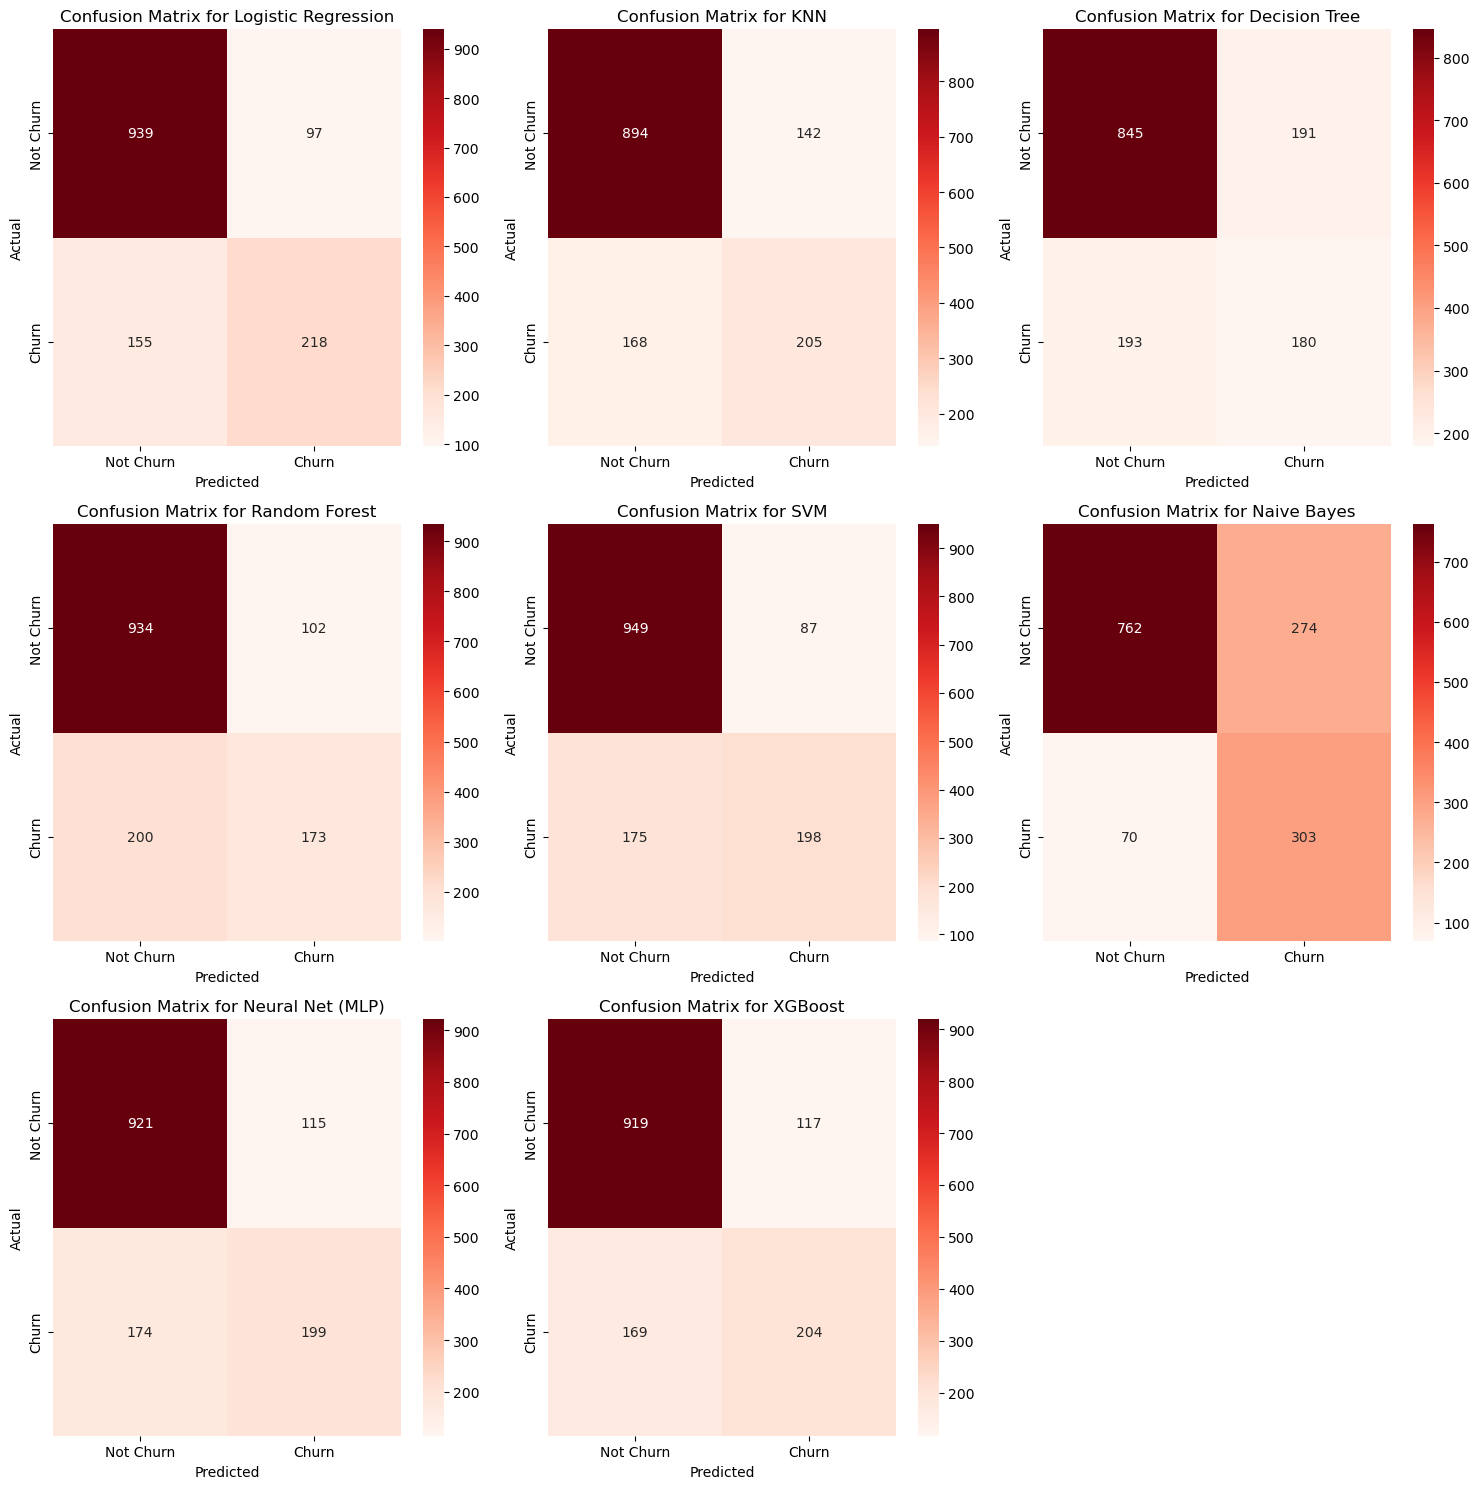

In [ ]:
from sklearn.metrics import confusion_matrix as cm_function

fig, ax = plt.subplots(3, 3, figsize=(15, 15)) 
ax = ax.flatten()

for i, model in enumerate(confusion_matrix):
    cm = cm_function(y_test, model["y_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax[i])
    ax[i].set_title(f'Confusion Matrix for {model["Model"]}')
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Actual')

for j in range(len(confusion_matrix), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [78]:
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ➤ Modèles à évaluer
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Neural Net (MLP)": MLPClassifier(max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# ➤ Métriques à calculer
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# ➤ Configuration de la validation croisée (5 folds stratifiés)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ➤ Stockage des résultats
results = []

# ➤ Boucle sur les modèles avec validation croisée
for name, model in models.items():
    # Création d'un pipeline (standardisation + modèle)
    pipeline = make_pipeline(StandardScaler(), model) if name != "Decision Tree" and name != "Random Forest" and name != "XGBoost" else model
    
    # Cross-validation
    cv_results = cross_validate(
        pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Moyenne des scores sur les folds
    mean_scores = {
        "Model": name,
        "Accuracy": round(cv_results['test_accuracy'].mean(), 3),
        "Precision": round(cv_results['test_precision'].mean(), 3),
        "Recall": round(cv_results['test_recall'].mean(), 3),
        "F1-Score": round(cv_results['test_f1'].mean(), 3),
        "ROC AUC": round(cv_results['test_roc_auc'].mean(), 3),
        "Fit Time (s)": round(cv_results['fit_time'].mean(), 3)
    }
    results.append(mean_scores)

# ➤ Affichage des résultats
df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print(df_results)

c:\Users\GTR\miniconda3\envs\da311\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\GTR\miniconda3\envs\da311\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\GTR\miniconda3\envs\da311\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


                 Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
5          Naive Bayes     0.746      0.515   0.780     0.620    0.831   
0  Logistic Regression     0.802      0.652   0.542     0.592    0.843   
4                  SVM     0.794      0.643   0.500     0.562    0.802   
7              XGBoost     0.786      0.617   0.516     0.562    0.821   
3        Random Forest     0.786      0.624   0.488     0.548    0.817   
6     Neural Net (MLP)     0.775      0.590   0.492     0.536    0.805   
1                  KNN     0.754      0.539   0.502     0.520    0.768   
2        Decision Tree     0.723      0.477   0.487     0.482    0.648   

   Fit Time (s)  
5         0.015  
0         0.052  
4         6.279  
7         0.732  
3         0.668  
6         5.910  
1         0.018  
2         0.031  
